### 3-SAT Problem 

$f(v1,v2,v3)= (¬v1 \lor ¬v2 \lor ¬v3)\land (v1 \lor ¬v2 \lor v3) \land (v1 \lor v2 \lor ¬v3) \land (v1 \lor ¬v2 \lor ¬v3) \land (¬v1\lor v2\lor v3)$    
Can be reduced to:
$$ f(v1, v2, v3) = ¬c1 \land ¬c2 \land ¬c3 \land ¬c4 \land ¬c5$$ where,
    $$ c1 = (v1 \land v2 \land v3)$$
    $$ c2 = (¬v1 \land v2 \land ¬v3)  $$
    $$ c3 = (¬v1 \land ¬v2 \land v3)$$
    $$ c4 = (¬v1 \land v2 \land v3)$$
    $$ c5 = (v1 \land ¬v2 \land ¬v3)$$


In our solution, we used an array of booleans to know if we needed to apply an X gate to a certain variable


In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_distribution
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=False):
    
    #define backend
    device = Aer.get_backend('qasm_simulator')
    #get counts
    counts = execute(qc, device, shots=shots).result().get_counts()
    
    if decimal:
        if reversed:
            counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
        else:
            counts = dict((int(a,2),b) for (a,b) in counts.items())
    else:
        if reversed:
            counts = dict((a[::-1],b) for (a,b) in counts.items())
        else:
            counts = dict((a,b) for (a,b) in counts.items())

    return counts

#### Function initial_state(formula)
This function applies the Hadamard gate to the first 3 qubits turning them into a superposition state. Then it negates all the ancillas created for every formula, plus the last one which is the ancilla that we use to aggregate all results. 

In [3]:
def initial_state(formula):
    qr = QuantumRegister(3)
    ancilla = QuantumRegister(len(formula) + 1)
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr, ancilla, cr)

    qc.h(qr)
    
    qc.x(ancilla)
    qc.h(ancilla)
    
    
    qc.barrier()
    
    return qc, qr, ancilla, cr

#### Oracle(qr, ancilla, formulas)
    qr - Quantum registers
    ancilla - Ancillas used on this problem
    formulas - Boolean matrix with the formulas

In [4]:
def oracle(qr, ancilla, formula):
    qc = QuantumCircuit(qr, ancilla)
    
    for i, formula in enumerate(formula):
        for j in range(0, 3):
            if formula[j] == False:
                qc.x(qr[j])
                
        qc.mcx(qr, ancilla[i])
        qc.x(ancilla[i])
        
        for j in range(0, 3):
            if formula[j] == False:
                qc.x(qr[j])
        
        qc.barrier()
    # aggregate all results
    qc.mcx(ancilla[:-1],ancilla[-1])
    qc.barrier()
    return qc

In [5]:
def diffusion_operator(qr, ancilla):
    qc = QuantumCircuit(qr,ancilla)
    
    qc.h(qr)
    qc.x(qr)
    qc.ccz(qr[0], qr[1], qr[2])
    qc.x(qr)
    qc.h(qr)
    
    qc.barrier()
    return qc 

In [6]:
def grover(qc, qr, ancilla, oracle, formula):
    elements = 2**3

    iterations = int(np.floor(np.pi/4 * np.sqrt(elements)))

    for j in range(iterations):
        qc = qc.compose(oracle(qr, ancilla, formula))
        qc = qc.compose(diffusion_operator(qr, ancilla))
    return qc

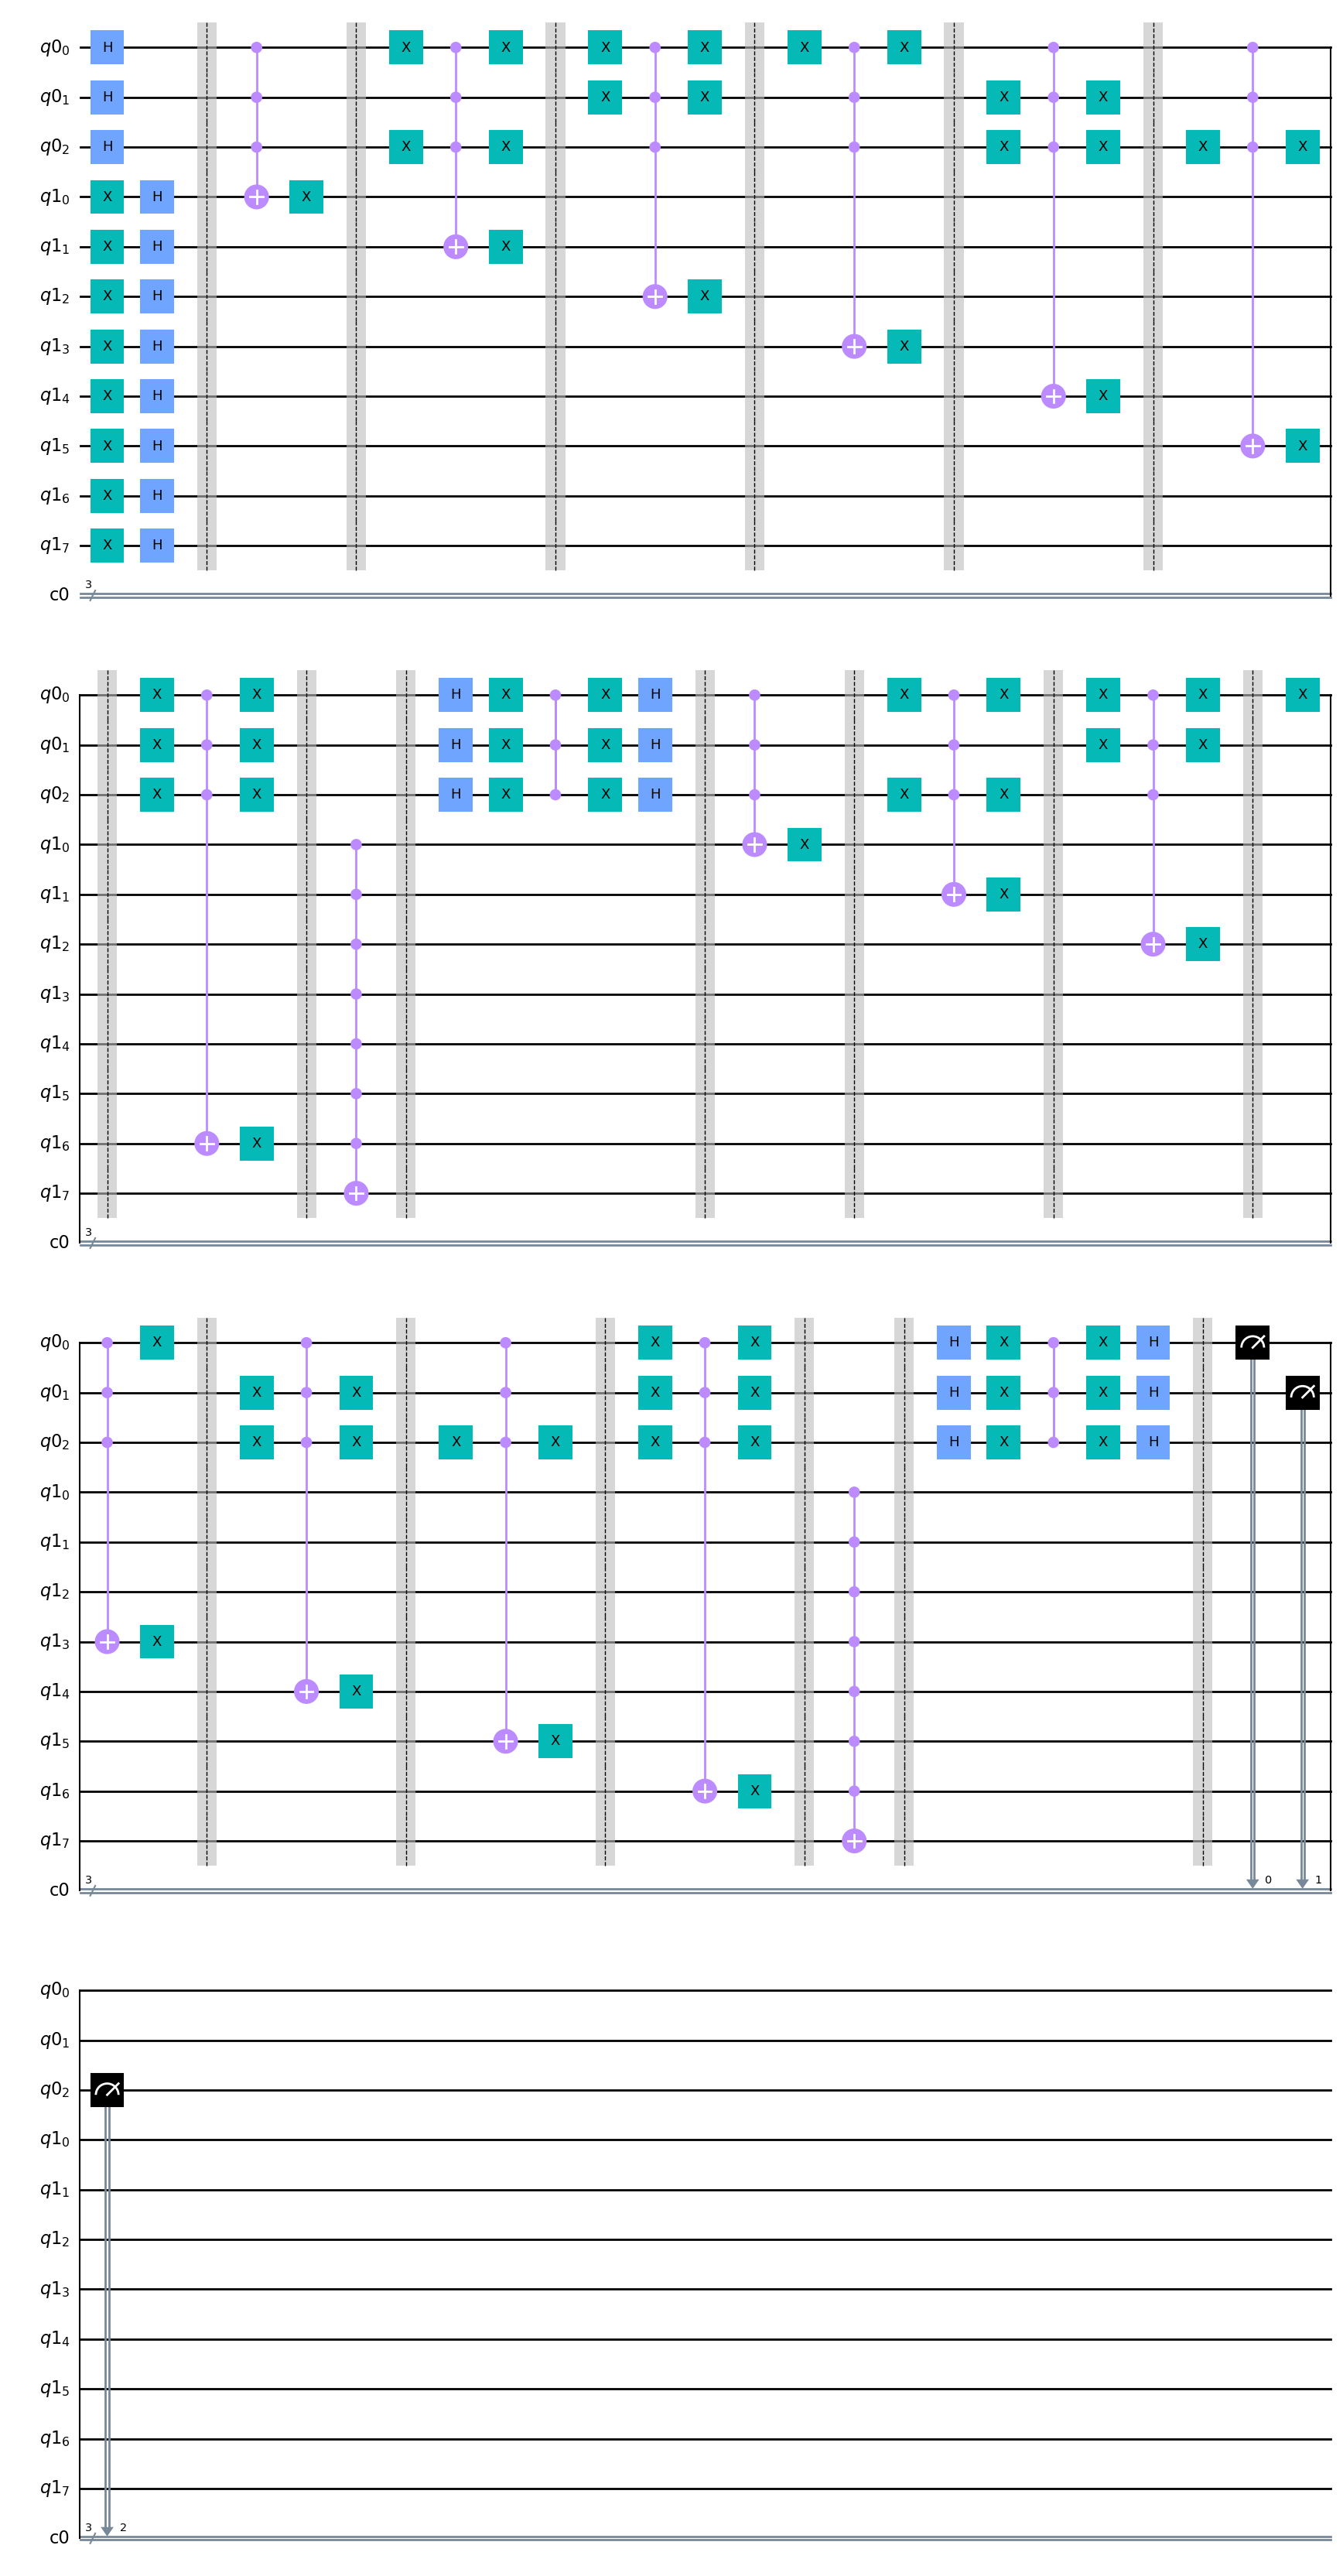

In [7]:
formula = [
    [True, True, True],
    [False, True, False],
    [False, False, True],
    [False, True, True],
    [True, False, False],
    [True, True, False],
    [False, False, False]
] 

qc, qr, ancilla, cr = initial_state(formula)
qc = grover(qc, qr, ancilla, oracle, formula)
qc.measure(qr, cr)
qc.draw(output="mpl")

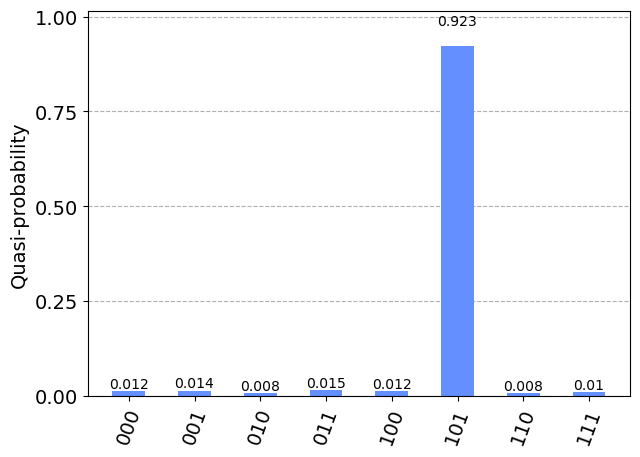

In [9]:
plot_distribution(execute_circuit(qc, 1024))